In [1]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm

while os.path.basename(os.getcwd()) != "T2T_ViT":
    os.chdir('..')

from datasets.datamodules import CIFAR10DataModule, GastroDataModule, DataModuleWithMasks, GenerateMasksKwargs
from lightning_modules.classifier import Classifier
from lightning_modules.surrogate import Surrogate
from vit_shapley.masks import apply_masks_to_batch
from vit_shapley.visualizations import to_image_grid

if torch.cuda.device_count() > 1:
    torch.cuda.set_device(3)

In [2]:
datamodule = DataModuleWithMasks(
    CIFAR10DataModule(),
    GenerateMasksKwargs(num_players=16),
    dict(batch_size=32)
)
datamodule.setup("test")
data = next(iter(datamodule.test_dataloader()))

images = data['image']
labels = data['label']
masks = data['mask']
print(images.shape, labels.shape, masks.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 16])


<font size="12">Target model visualization</font>

In [3]:
classifier = Classifier.load_from_latest_checkpoint("saved_models/classifier/cifar10/v4/vit_small_patch16_224")
classifier.eval()
classifier.to("cuda")

# Predict with the model.
logits = classifier(images.cuda())
print(f'logits shape is {tuple(logits.shape)}')
preds = torch.argmax(logits, dim=1)

	input_size:	(3, 224, 224)
	interpolation:	bicubic
	mean:	(0.5, 0.5, 0.5)
	std:	(0.5, 0.5, 0.5)
logits shape is (32, 10)


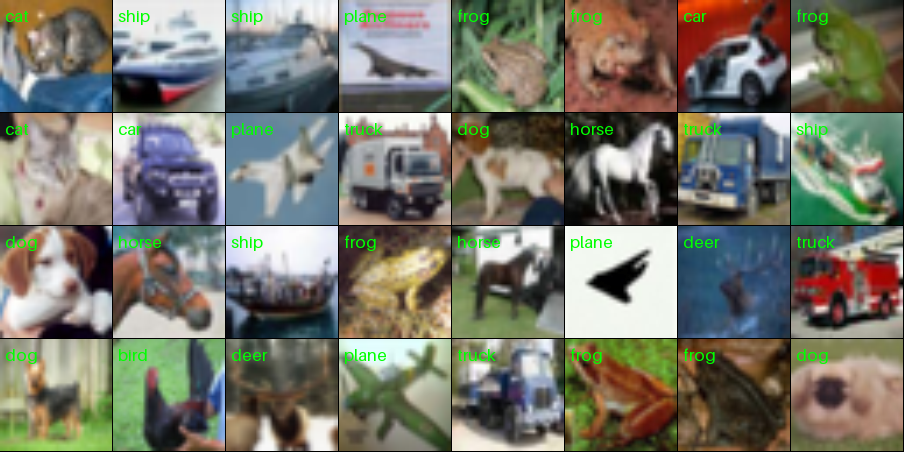

In [4]:
colors = [(0, 255, 0) if l == p else (255, 0, 0) for l, p in zip(labels, preds)]
to_image_grid(images, preds, colors, scale=1/2)

In [5]:
def test_without_masks(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device: str = "cuda") -> None:
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets = d['image'], d['label']
            images, targets = images.to(device), targets.to(device)
            logits = model(images)
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')

test_without_masks(classifier, datamodule.test_dataloader())

Accuracy: 97.70%: 100%|██████████| 313/313 [00:19<00:00, 16.43it/s]


<font size="12">Surrogate model visualization</font>

In [6]:
print(images.shape, labels.shape, masks.shape)
images_masked, masks_masked, labels_masked = apply_masks_to_batch(images, masks, labels)
print(images_masked.shape, labels_masked.shape, masks_masked.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32, 2, 16])
torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64, 16])


In [7]:
surrogate = Surrogate.load_from_latest_checkpoint("saved_models/surrogate/cifar10/v4/player16/vit_small_patch16_224")
surrogate.eval()
print(datamodule.num_players, surrogate.num_players)

16 16


logits.shape=torch.Size([64, 10]), preds.shape=torch.Size([64]), labels_masked.shape=torch.Size([64])


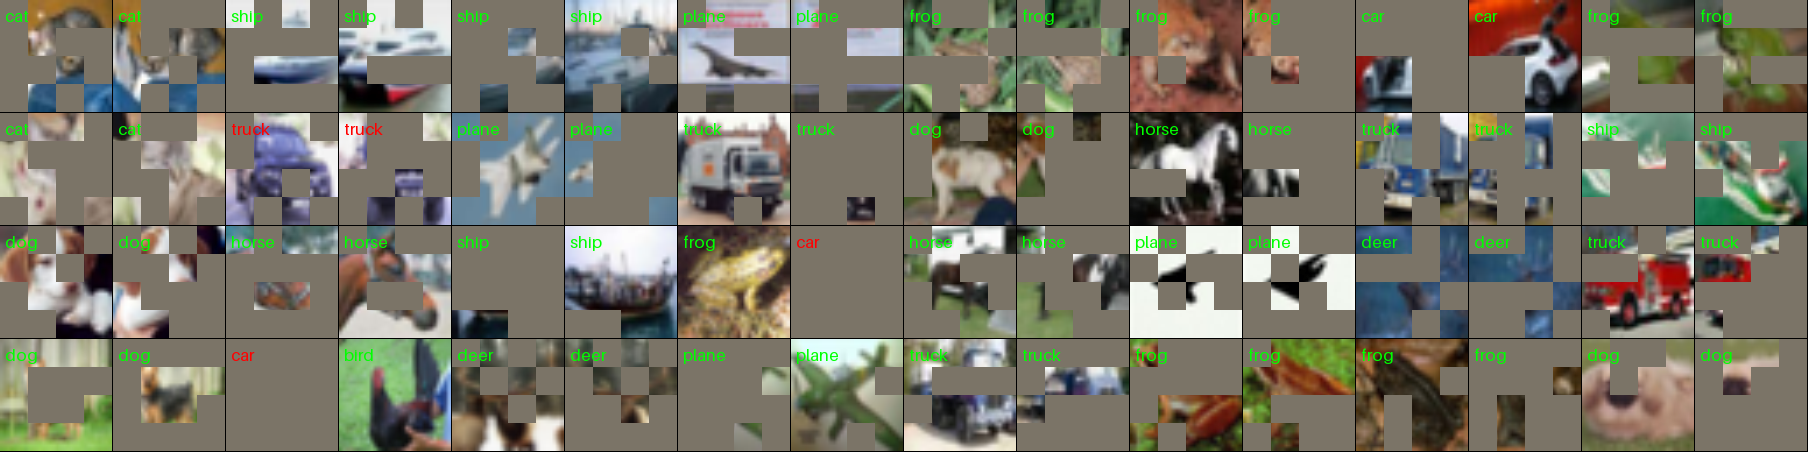

In [8]:
logits = surrogate(images_masked.to(surrogate.device))
preds = torch.argmax(logits, dim=1).cpu()
print(f'{logits.shape=}, {preds.shape=}, {labels_masked.shape=}')
colors = [(0, 255, 0) if lbl == p else (255, 0, 0) for lbl, p in zip(labels_masked, preds)]
to_image_grid(images_masked, preds, colors, scale=1/2, n_columns=2 * 8)

In [9]:
test_without_masks(surrogate, datamodule.test_dataloader())

Accuracy: 98.63%:   5%|▌         | 16/313 [00:00<00:17, 16.72it/s]

Accuracy: 98.21%: 100%|██████████| 313/313 [00:18<00:00, 16.73it/s]


# Performance on masked images

In [10]:
def test_masked(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader, device="cuda") -> None:
    results = []
    masked_percentages = []
    with torch.no_grad():
        model.to(device)
        correct, total = 0, 0
        progress = tqdm(dataloader)
        for d in progress:
            images, targets, masks = d['image'], d['label'], d['mask']
            images, targets, masks = images.to(device), targets.to(device), masks.to(device)
            images, masks, targets = apply_masks_to_batch(images, masks, targets)
            logits = model(images)
            if hasattr(logits, "logits"):
                logits = logits.logits
            _, predicted = logits.max(dim=1)
            total += targets.shape[0]
            correct += predicted.eq(targets).sum().item()
            results.extend(predicted.eq(targets).cpu().numpy())
            masked_percentages.extend((1 - masks).to(torch.float).mean(dim=1).cpu().numpy() * 100)
            progress.set_description(f'Accuracy: {100.0 * correct / total:.2f}%')
    return pd.DataFrame({'result': results, 'masked %': masked_percentages})

all_results = {}

In [11]:
all_results["classifier"] = test_masked(classifier, datamodule.test_dataloader())

Accuracy: 74.67%: 100%|██████████| 313/313 [00:27<00:00, 11.21it/s]


In [12]:
all_results["surrogate"] = test_masked(surrogate, datamodule.test_dataloader())

Accuracy: 85.59%: 100%|██████████| 313/313 [00:27<00:00, 11.57it/s]


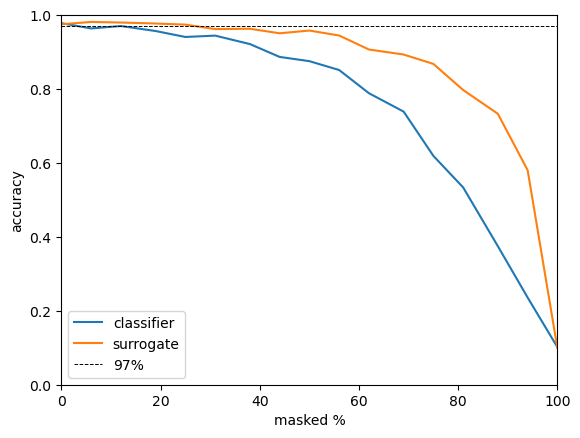

In [13]:
bucket_size = 1.0
for k, df in all_results.items():
    df['masked %'] = df['masked %'].div(bucket_size).round().astype(int).mul(bucket_size)

plt.figure()
for k, df in all_results.items():
    plt.plot(df.groupby('masked %').mean(), label=k)
plt.plot([0, 100], [0.97, 0.97], color='black', linestyle='dashed', linewidth=0.7, label='97%')
plt.legend()
plt.xlabel('masked %')
plt.ylabel('accuracy')
plt.xlim(0, 100)
plt.ylim(0, 1)
plt.show()